## Introduction

I present a reimplementation of the following paper:

> Seppecher, P. (2012). Flexibility of wages and macroeconomic instability in an agent-based computational model with endogenous money. Macroeconomic Dynamics, 16(S2), 284-297.

After replicating the results of the original paper, I present some new questions to examine which test the robustness of the original model.

## Original model

The original paper implements the simulation using Jamel v1 software written by the author. Here I present a top-down reimplementation of the model from the original paper, with the following adjustments:

* Cash values are represented as cents and stored as `int` type, to prevent rounding and representation issues with floating-point numbers.
* Real-valued parameters are likewise represented as an arbitrary-precision `Fraction` type.
* All entities are immutable [why?]
* Entity types have no methods. Instead entity types are purely data stores, and all model mechanics are represented as separate functions. This allows me to write the code in a less fragmented manner, improving readability.

In [104]:
%run seppecher2012.py

from itertools import accumulate

sim = new_sim()
run = [sim]
for i in range(60):
    if i % 10 == 0:
        print("Step {}".format(i))
    next = run[-1]
    if i == 50:
        next = next._replace(
            bank = next.bank._replace(
                accommodating = False
            )
        )
    run.append(step(next))

Step 0
Step 10
Step 20
Step 30
Step 40
Step 50


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

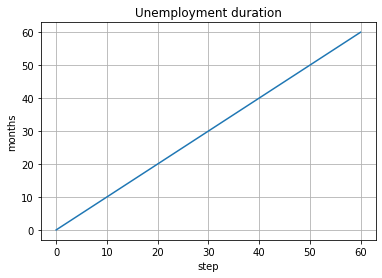

In [105]:
def unemployment_duration(step):
    unemployed = [household for household in list(step.households.values()) if household.employment_status != EmploymentStatus.EMPLOYED]
    return sum([household.unemployment_duration for household in unemployed]) / len(unemployed)

def plot_unemployment_duration(run):
    durations = [unemployment_duration(step) for step in run]
    fig, ax = plt.subplots()
    ax.plot(range(len(durations)), durations)

    ax.set(xlabel='step', ylabel='months',
        title='Unemployment duration')
    ax.grid()

    plt.show()

plot_unemployment_duration(run)

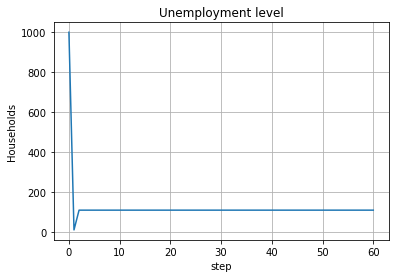

In [110]:

def unemployment_level(step):
    unemployed = [household for household in list(step.households.values()) if household.employment_status != EmploymentStatus.EMPLOYED]
    return len(unemployed)

def plot_unemployment_level(run):
    level = [unemployment_level(step) for step in run]
    fig, ax = plt.subplots()
    ax.plot(range(len(level)), level)

    ax.set(xlabel='step', ylabel='Households',
        title='Unemployment level')
    ax.grid()

    plt.show()

plot_unemployment_level(run)

In [100]:
randrange(6,7)

6